In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, LSTM, LayerNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import textalloc as ta
import optuna
import xgboost as xgb

/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
DATA = pd.read_csv('../data/processed/throwing_0627.csv').dropna(how='any', axis=0)

In [5]:
trainIDs, testIDs = train_test_split(DATA.gameID.unique(), test_size=0.2, random_state=42)

In [6]:
def add_team_swap(data):
    all_games = []
    for game in data.gameID.unique():
        GAME = data[data.gameID == game]
        GAME['temp'] = GAME['home_team_score']
        GAME['home_team_score'] = GAME['away_team_score']
        GAME['away_team_score'] = GAME['temp']
        GAME['home_team_win'] = (~GAME.home_team_win.astype(bool)).astype(int)
        GAME['is_home_team'] = ~GAME['is_home_team']
        GAME['gameID'] = GAME['gameID'] + '-teamswap'
        all_games.append(GAME.drop('temp', axis=1))
    return pd.concat([pd.concat(all_games), data])

def add_x_swap(data):
    FLIPPED_X = data.copy()
    FLIPPED_X.thrower_x = FLIPPED_X.thrower_x * -1
    FLIPPED_X['gameID'] = FLIPPED_X['gameID'] + '-throwswap'
    return pd.concat([data, FLIPPED_X])

def pad_arrays(array, max_length):
    padded_arrays = []
    for arr in array:
        pad_width = ((max_length - len(arr), 0), (0, 0))  # Pad at the beginning with zeros
        padded_array = np.pad(arr, pad_width, mode='constant', constant_values=-1)
        padded_arrays.append(padded_array)
    return padded_arrays

def process_data(data, features):
    _, testIDs = train_test_split(DATA.gameID.unique(), test_size=0.2, random_state=42)
    data = add_team_swap(data)
    data = add_x_swap(data)
    label = ['home_team_win']

    grouped = data.groupby(['gameID'])

    # Step 2: Sort the groups by length
    sorted_groups = sorted(grouped[features + label], key=lambda x: len(x[1]), reverse=True)

    # Step 3: Convert each group to a numpy array
    group_train_arrays = []
    group_test_arrays = []
    max_length = 0
    for gameID, group in sorted_groups:
        group_array = group.values  # Convert group DataFrame to a numpy array
        if len(group_array) > max_length:
            max_length = len(group_array)
        if gameID in testIDs:
            group_test_arrays.append(group_array)
        else:
            group_train_arrays.append(group_array)

    # Step 4: Pad the variable-length groups
    padded_train_arrays = pad_arrays(group_train_arrays, max_length)
    padded_test_arrays = pad_arrays(group_test_arrays, max_length)

    # Step 5: Convert the list of arrays into a 3D numpy array
    data_train_array = np.stack(padded_train_arrays)
    data_test_array = np.stack(padded_test_arrays)

    X_train, X_test, y_train, y_test = data_train_array[:,:,:-1], data_test_array[:,:,:-1], data_train_array[:,:,-1], data_test_array[:,:,-1]
    
    # Create a normalizer object
    normalizer = MinMaxScaler()

    # Flatten the 3D training data
    X_train_flattened = X_train.reshape(-1, X_train.shape[-1])

    # Create a mask for padded values
    mask = (X_train_flattened[:, 0] != -1)

    # Apply normalization only to non-padded values
    X_train_normalized = X_train_flattened.copy()
    X_train_normalized[mask] = normalizer.fit_transform(X_train_flattened[mask])

    # Reshape the normalized data back to the original shape
    X_train_normalized = X_train_normalized.reshape(X_train.shape)

    # Apply the same normalization to the test data
    X_test_flattened = X_test.reshape(-1, X_test.shape[-1])
    mask = (X_test_flattened[:, 0] != -1)
    X_test_flattened = X_test.reshape(-1, X_test.shape[-1])
    X_test_normalized = X_test_flattened.copy()
    X_test_normalized[mask] = normalizer.transform(X_test_flattened[mask])
    X_test_normalized = X_test_normalized.reshape(X_test.shape)

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    X_train_normalized = X_train_normalized.astype(np.float32)
    X_test_normalized = X_test_normalized.astype(np.float32)
    return X_train_normalized, X_test_normalized, y_train, y_test, normalizer

In [7]:
def create_model(lstm_units, input_shape):
    model = tf.keras.Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(LayerNormalization())
    model.add(Dense(units=1, activation='sigmoid'))
    return model

def masked_loss(mask_value):
    def loss_function(y_true, y_pred):
        mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
        loss = K.binary_crossentropy(y_true * mask, y_pred * mask)
        return loss
    return loss_function

In [8]:
def objective(trial, X_train, X_test, y_train, y_test, eval=False):
    # Define the hyperparameters to tune
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    num_epochs = 100
    batch_size = trial.suggest_categorical('batch_size',[16,32,64])

    # Create the model instance
    model = create_model(lstm_units, (X_train.shape[1], X_train.shape[2]))

    # Define the optimizer and learning rate scheduler
    optimizer = Adam(learning_rate=learning_rate)
    scheduler = LearningRateScheduler(lambda epoch: learning_rate * 0.1 ** (epoch // 10))
    # Define early stopping callback
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer=optimizer, loss=masked_loss(-1), metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test, y_test), callbacks=[scheduler, early_stopping])

    loss, accuracy = model.evaluate(X_test, y_test)

    if eval:
        return model

    # Return the evaluation metric (e.g., accuracy)
    return loss

In [9]:
def accuracy_objective(trial, X_train, X_test, y_train, y_test, eval=False):
    # Define the hyperparameters to tune
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    num_epochs = 100
    batch_size = trial.suggest_categorical('batch_size',[16,32,64])

    # Create the model instance
    model = create_model(lstm_units, (X_train.shape[1], X_train.shape[2]))

    # Define the optimizer and learning rate scheduler
    optimizer = Adam(learning_rate=learning_rate)
    scheduler = LearningRateScheduler(lambda epoch: learning_rate * 0.1 ** (epoch // 10))
    # Define early stopping callback
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer=optimizer, loss=masked_loss(-1), metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test, y_test), callbacks=[scheduler, early_stopping])

    loss, accuracy = model.evaluate(X_test, y_test)

    if eval:
        return model

    # Return the evaluation metric (e.g., accuracy)
    return accuracy

In [26]:
storage='sqlite:///test_db.db'
study_name='lstm_v1'
optuna.delete_study(storage=storage, study_name=study_name)

In [23]:
X_test.shape

(71, 600, 12)

In [29]:
storage='sqlite:///test_db.db'
study_name='lstm_v1'
features = ['thrower_x', 'thrower_y', 'possession_num', 'possession_throw',
       'game_quarter', 'quarter_point', 'is_home_team', 'home_team_score',
       'away_team_score','total_points', 'times', 'score_diff']
X_train, X_test, y_train, y_test, normalizer = process_data(DATA, features)
study = optuna.create_study(direction='minimize', storage=storage, study_name=study_name)
objective_lambda = lambda trial: objective(trial, X_train, X_test, y_train, y_test)
study.optimize(objective_lambda, n_trials=5)

/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GAME['temp'] = GAME['home_team_score']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GAME['home_team_score'] = GAME['away_team_score']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Epoch 1/100


2023-06-28 16:43:23.507352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:43:23.861802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:43:25.641900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 0.5855 - accuracy: 0.3863

2023-06-28 16:43:38.539466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:43:38.661760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 19s 586ms/step - loss: 0.5855 - accuracy: 0.3863 - val_loss: 0.5522 - val_accuracy: 0.4146 - lr: 1.6794e-04
Epoch 2/100
21/21 [==============================] - 5s 221ms/step - loss: 0.5046 - accuracy: 0.4201 - val_loss: 0.5049 - val_accuracy: 0.4602 - lr: 1.6794e-04
Epoch 3/100
21/21 [==============================] - 4s 203ms/step - loss: 0.4831 - accuracy: 0.4919 - val_loss: 0.5057 - val_accuracy: 0.4812 - lr: 1.6794e-04
Epoch 4/100
21/21 [==============================] - 4s 207ms/step - loss: 0.4719 - accuracy: 0.5028 - val_loss: 0.4875 - val_accuracy: 0.4748 - lr: 1.6794e-04
Epoch 5/100
21/21 [==============================] - 4s 205ms/step - loss: 0.4545 - accuracy: 0.5384 - val_loss: 0.4806 - val_accuracy: 0.4966 - lr: 1.6794e-04
Epoch 6/100
21/21 [==============================] - 5s 217ms/step - loss: 0.4397 - accuracy: 0.5477 - val_loss: 0.4937 - val_accuracy: 0.5455 - lr: 1.6794e-04
Epoch 7/100
21/21 [==============================] 

[I 2023-06-28 16:44:40,713] Trial 0 finished with value: 0.8931191563606262 and parameters: {'batch_size': 64, 'learning_rate': 0.0001679371636850058, 'lstm_units': 84}. Best is trial 0 with value: 0.8931191563606262.


Epoch 1/100


2023-06-28 16:44:41.855909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:44:42.258132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:44:44.165713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.3881

2023-06-28 16:45:07.324628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:45:07.453894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 29s 267ms/step - loss: 0.5231 - accuracy: 0.3881 - val_loss: 0.4401 - val_accuracy: 0.5176 - lr: 1.2564e-04
Epoch 2/100
84/84 [==============================] - 13s 159ms/step - loss: 0.4583 - accuracy: 0.4867 - val_loss: 0.4041 - val_accuracy: 0.5762 - lr: 1.2564e-04
Epoch 3/100
84/84 [==============================] - 14s 164ms/step - loss: 0.3820 - accuracy: 0.5410 - val_loss: 0.3310 - val_accuracy: 0.5999 - lr: 1.2564e-04
Epoch 4/100
84/84 [==============================] - 15s 182ms/step - loss: 0.3574 - accuracy: 0.5490 - val_loss: 0.3071 - val_accuracy: 0.5933 - lr: 1.2564e-04
Epoch 5/100
84/84 [==============================] - 14s 170ms/step - loss: 0.3445 - accuracy: 0.5582 - val_loss: 0.3089 - val_accuracy: 0.6059 - lr: 1.2564e-04
Epoch 6/100
84/84 [==============================] - 15s 177ms/step - loss: 0.3346 - accuracy: 0.5634 - val_loss: 0.3235 - val_accuracy: 0.5963 - lr: 1.2564e-04
Epoch 7/100
84/84 [===========================

[I 2023-06-28 16:50:01,793] Trial 1 finished with value: 0.29859334230422974 and parameters: {'batch_size': 16, 'learning_rate': 0.00012564136348470068, 'lstm_units': 92}. Best is trial 1 with value: 0.29859334230422974.


Epoch 1/100


2023-06-28 16:50:02.940467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:50:03.278734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:50:05.106369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 0.6097 - accuracy: 0.3783

2023-06-28 16:50:20.633724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:50:20.770142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 22s 359ms/step - loss: 0.6097 - accuracy: 0.3783 - val_loss: 0.4855 - val_accuracy: 0.4778 - lr: 0.0029
Epoch 2/100
42/42 [==============================] - 7s 168ms/step - loss: 0.4631 - accuracy: 0.4837 - val_loss: 0.3757 - val_accuracy: 0.5721 - lr: 0.0029
Epoch 3/100
42/42 [==============================] - 7s 167ms/step - loss: 0.4118 - accuracy: 0.5067 - val_loss: 0.3922 - val_accuracy: 0.5444 - lr: 0.0029
Epoch 4/100
42/42 [==============================] - 7s 166ms/step - loss: 0.3540 - accuracy: 0.5568 - val_loss: 0.3368 - val_accuracy: 0.5931 - lr: 0.0029
Epoch 5/100
42/42 [==============================] - 7s 169ms/step - loss: 0.3356 - accuracy: 0.5660 - val_loss: 0.3216 - val_accuracy: 0.5719 - lr: 0.0029
Epoch 6/100
42/42 [==============================] - 7s 169ms/step - loss: 0.3262 - accuracy: 0.5684 - val_loss: 0.2963 - val_accuracy: 0.5980 - lr: 0.0029
Epoch 7/100
42/42 [==============================] - 7s 168ms/step - loss: 

[I 2023-06-28 16:51:34,816] Trial 2 finished with value: 0.29632893204689026 and parameters: {'batch_size': 32, 'learning_rate': 0.002945853756965153, 'lstm_units': 128}. Best is trial 2 with value: 0.29632893204689026.


Epoch 1/100


2023-06-28 16:51:35.999120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:51:36.479723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:51:38.155566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.4692

2023-06-28 16:51:53.636191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:51:53.781145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 22s 357ms/step - loss: 0.4782 - accuracy: 0.4692 - val_loss: 0.5799 - val_accuracy: 0.3006 - lr: 0.0061
Epoch 2/100
42/42 [==============================] - 7s 165ms/step - loss: 0.4108 - accuracy: 0.5199 - val_loss: 0.3732 - val_accuracy: 0.5872 - lr: 0.0061
Epoch 3/100
42/42 [==============================] - 7s 162ms/step - loss: 0.3985 - accuracy: 0.5239 - val_loss: 0.4416 - val_accuracy: 0.4816 - lr: 0.0061
Epoch 4/100
42/42 [==============================] - 7s 161ms/step - loss: 0.3324 - accuracy: 0.5668 - val_loss: 0.3327 - val_accuracy: 0.5919 - lr: 0.0061
Epoch 5/100
42/42 [==============================] - 7s 162ms/step - loss: 0.3360 - accuracy: 0.5633 - val_loss: 0.4103 - val_accuracy: 0.5400 - lr: 0.0061
Epoch 6/100
42/42 [==============================] - 7s 162ms/step - loss: 0.3625 - accuracy: 0.5485 - val_loss: 0.3324 - val_accuracy: 0.5806 - lr: 0.0061
Epoch 7/100
42/42 [==============================] - 7s 161ms/step - loss: 

[I 2023-06-28 16:54:07,586] Trial 3 finished with value: 0.29629379510879517 and parameters: {'batch_size': 32, 'learning_rate': 0.006108707324452222, 'lstm_units': 45}. Best is trial 3 with value: 0.29629379510879517.


Epoch 1/100


2023-06-28 16:54:08.750769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:54:09.227143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:54:10.871202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - ETA: 0s - loss: 0.5852 - accuracy: 0.4050

2023-06-28 16:54:32.396452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:54:32.544262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 28s 252ms/step - loss: 0.5852 - accuracy: 0.4050 - val_loss: 0.5345 - val_accuracy: 0.3518 - lr: 9.5043e-05
Epoch 2/100
84/84 [==============================] - 14s 163ms/step - loss: 0.4777 - accuracy: 0.4768 - val_loss: 0.4899 - val_accuracy: 0.4672 - lr: 9.5043e-05
Epoch 3/100
84/84 [==============================] - 15s 179ms/step - loss: 0.4584 - accuracy: 0.5079 - val_loss: 0.4651 - val_accuracy: 0.5229 - lr: 9.5043e-05
Epoch 4/100
84/84 [==============================] - 15s 179ms/step - loss: 0.4342 - accuracy: 0.5336 - val_loss: 0.4265 - val_accuracy: 0.5737 - lr: 9.5043e-05
Epoch 5/100
84/84 [==============================] - 14s 171ms/step - loss: 0.4116 - accuracy: 0.5382 - val_loss: 0.4034 - val_accuracy: 0.5839 - lr: 9.5043e-05
Epoch 6/100
84/84 [==============================] - 14s 163ms/step - loss: 0.3839 - accuracy: 0.5518 - val_loss: 0.3725 - val_accuracy: 0.5832 - lr: 9.5043e-05
Epoch 7/100
84/84 [===========================

[I 2023-06-28 16:59:45,591] Trial 4 finished with value: 0.31279993057250977 and parameters: {'batch_size': 16, 'learning_rate': 9.504257859613933e-05, 'lstm_units': 44}. Best is trial 3 with value: 0.29629379510879517.


In [31]:
storage='sqlite:///test_db.db'
study_name='lstm_v1_accuracy'
features = ['thrower_x', 'thrower_y', 'possession_num', 'possession_throw',
       'game_quarter', 'quarter_point', 'is_home_team', 'home_team_score',
       'away_team_score','total_points', 'times', 'score_diff']
X_train, X_test, y_train, y_test, normalizer = process_data(DATA, features)
study = optuna.create_study(direction='maximize', storage=storage, study_name=study_name)
objective_lambda = lambda trial: accuracy_objective(trial, X_train, X_test, y_train, y_test)
study.optimize(objective_lambda, n_trials=5)

/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GAME['temp'] = GAME['home_team_score']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GAME['home_team_score'] = GAME['away_team_score']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Epoch 1/100


2023-06-28 16:59:54.728049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:59:55.113227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 16:59:56.951124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - ETA: 0s - loss: 0.4647 - accuracy: 0.4715

2023-06-28 17:00:19.629685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:00:19.827148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 29s 269ms/step - loss: 0.4647 - accuracy: 0.4715 - val_loss: 0.3868 - val_accuracy: 0.5310 - lr: 0.0025
Epoch 2/100
84/84 [==============================] - 14s 169ms/step - loss: 0.3566 - accuracy: 0.5544 - val_loss: 0.3202 - val_accuracy: 0.5747 - lr: 0.0025
Epoch 3/100
84/84 [==============================] - 14s 168ms/step - loss: 0.3555 - accuracy: 0.5553 - val_loss: 0.3094 - val_accuracy: 0.6030 - lr: 0.0025
Epoch 4/100
84/84 [==============================] - 14s 168ms/step - loss: 0.3552 - accuracy: 0.5512 - val_loss: 0.3046 - val_accuracy: 0.5971 - lr: 0.0025
Epoch 5/100
84/84 [==============================] - 14s 166ms/step - loss: 0.3600 - accuracy: 0.5500 - val_loss: 0.3113 - val_accuracy: 0.6136 - lr: 0.0025
Epoch 6/100
84/84 [==============================] - 14s 167ms/step - loss: 0.3300 - accuracy: 0.5700 - val_loss: 0.3620 - val_accuracy: 0.5681 - lr: 0.0025
Epoch 7/100
84/84 [==============================] - 14s 168ms/step - 

[I 2023-06-28 17:05:21,330] Trial 0 finished with value: 0.609664261341095 and parameters: {'batch_size': 16, 'learning_rate': 0.0025312155993455084, 'lstm_units': 36}. Best is trial 0 with value: 0.609664261341095.


Epoch 1/100


2023-06-28 17:05:22.609600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:05:23.046817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:05:24.704150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 0.5660 - accuracy: 0.4258

2023-06-28 17:05:41.348379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:05:41.649317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 23s 393ms/step - loss: 0.5660 - accuracy: 0.4258 - val_loss: 0.4415 - val_accuracy: 0.5000 - lr: 0.0038
Epoch 2/100
42/42 [==============================] - 8s 178ms/step - loss: 0.4186 - accuracy: 0.5086 - val_loss: 0.4855 - val_accuracy: 0.4194 - lr: 0.0038
Epoch 3/100
42/42 [==============================] - 8s 182ms/step - loss: 0.3383 - accuracy: 0.5650 - val_loss: 0.3218 - val_accuracy: 0.5707 - lr: 0.0038
Epoch 4/100
42/42 [==============================] - 8s 178ms/step - loss: 0.3191 - accuracy: 0.5765 - val_loss: 0.4003 - val_accuracy: 0.5407 - lr: 0.0038
Epoch 5/100
42/42 [==============================] - 7s 175ms/step - loss: 0.3344 - accuracy: 0.5660 - val_loss: 0.3201 - val_accuracy: 0.5793 - lr: 0.0038
Epoch 6/100
42/42 [==============================] - 7s 177ms/step - loss: 0.3293 - accuracy: 0.5673 - val_loss: 0.3284 - val_accuracy: 0.5800 - lr: 0.0038
Epoch 7/100
42/42 [==============================] - 7s 176ms/step - loss: 

[I 2023-06-28 17:07:59,624] Trial 1 finished with value: 0.59938645362854 and parameters: {'batch_size': 32, 'learning_rate': 0.003788727844521107, 'lstm_units': 107}. Best is trial 0 with value: 0.609664261341095.


Epoch 1/100


2023-06-28 17:08:00.921331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:08:01.397945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:08:03.311048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.4696

2023-06-28 17:08:26.308048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:08:26.498766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 30s 270ms/step - loss: 0.4538 - accuracy: 0.4696 - val_loss: 0.4257 - val_accuracy: 0.5145 - lr: 6.3512e-04
Epoch 2/100
84/84 [==============================] - 14s 165ms/step - loss: 0.3593 - accuracy: 0.5492 - val_loss: 0.3581 - val_accuracy: 0.5668 - lr: 6.3512e-04
Epoch 3/100
84/84 [==============================] - 14s 167ms/step - loss: 0.3462 - accuracy: 0.5589 - val_loss: 0.3077 - val_accuracy: 0.5894 - lr: 6.3512e-04
Epoch 4/100
84/84 [==============================] - 14s 167ms/step - loss: 0.3457 - accuracy: 0.5567 - val_loss: 0.3404 - val_accuracy: 0.5765 - lr: 6.3512e-04
Epoch 5/100
84/84 [==============================] - 14s 165ms/step - loss: 0.3575 - accuracy: 0.5460 - val_loss: 0.3308 - val_accuracy: 0.5863 - lr: 6.3512e-04
Epoch 6/100
84/84 [==============================] - 14s 164ms/step - loss: 0.3499 - accuracy: 0.5506 - val_loss: 0.3010 - val_accuracy: 0.6044 - lr: 6.3512e-04
Epoch 7/100
84/84 [===========================

[I 2023-06-28 17:11:47,324] Trial 2 finished with value: 0.6024541854858398 and parameters: {'batch_size': 16, 'learning_rate': 0.0006351169104709094, 'lstm_units': 112}. Best is trial 0 with value: 0.609664261341095.


Epoch 1/100


2023-06-28 17:11:50.520006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:11:50.954993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:11:52.585924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - ETA: 0s - loss: 0.4855 - accuracy: 0.4434

2023-06-28 17:12:16.283347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:12:16.454587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 32s 279ms/step - loss: 0.4855 - accuracy: 0.4434 - val_loss: 0.4276 - val_accuracy: 0.4957 - lr: 0.0051
Epoch 2/100
84/84 [==============================] - 15s 173ms/step - loss: 0.3793 - accuracy: 0.5380 - val_loss: 0.3309 - val_accuracy: 0.5996 - lr: 0.0051
Epoch 3/100
84/84 [==============================] - 14s 167ms/step - loss: 0.3769 - accuracy: 0.5377 - val_loss: 0.3039 - val_accuracy: 0.6119 - lr: 0.0051
Epoch 4/100
84/84 [==============================] - 14s 172ms/step - loss: 0.3506 - accuracy: 0.5554 - val_loss: 0.2988 - val_accuracy: 0.6144 - lr: 0.0051
Epoch 5/100
84/84 [==============================] - 15s 173ms/step - loss: 0.3363 - accuracy: 0.5664 - val_loss: 0.3103 - val_accuracy: 0.5925 - lr: 0.0051
Epoch 6/100
84/84 [==============================] - 14s 167ms/step - loss: 0.3461 - accuracy: 0.5578 - val_loss: 0.3096 - val_accuracy: 0.6034 - lr: 0.0051
Epoch 7/100
84/84 [==============================] - 14s 167ms/step - 

[I 2023-06-28 17:14:16,170] Trial 3 finished with value: 0.614433765411377 and parameters: {'batch_size': 16, 'learning_rate': 0.005145758314872499, 'lstm_units': 45}. Best is trial 3 with value: 0.614433765411377.


Epoch 1/100


2023-06-28 17:14:17.544068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:14:18.061727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:14:20.044281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 0.7800 - accuracy: 0.3685

2023-06-28 17:14:33.982308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:14:34.170028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 21s 679ms/step - loss: 0.7800 - accuracy: 0.3685 - val_loss: 0.4952 - val_accuracy: 0.4794 - lr: 0.0413
Epoch 2/100
21/21 [==============================] - 13s 593ms/step - loss: 0.5246 - accuracy: 0.3827 - val_loss: 0.5121 - val_accuracy: 0.4458 - lr: 0.0413
Epoch 3/100
21/21 [==============================] - 6s 257ms/step - loss: 0.5176 - accuracy: 0.3822 - val_loss: 0.5709 - val_accuracy: 0.2702 - lr: 0.0413
Epoch 4/100
21/21 [==============================] - 5s 234ms/step - loss: 0.5212 - accuracy: 0.3652 - val_loss: 0.5012 - val_accuracy: 0.4794 - lr: 0.0413
Epoch 5/100
21/21 [==============================] - 5s 216ms/step - loss: 0.5226 - accuracy: 0.3689 - val_loss: 0.4960 - val_accuracy: 0.4794 - lr: 0.0413
Epoch 6/100
3/3 [==============================] - 2s 133ms/step - loss: 0.5011 - accuracy: 0.4794


[I 2023-06-28 17:15:13,209] Trial 4 finished with value: 0.4794330298900604 and parameters: {'batch_size': 64, 'learning_rate': 0.04126417742180162, 'lstm_units': 67}. Best is trial 3 with value: 0.614433765411377.


In [32]:
storage='sqlite:///test_db.db'
study_name='lstm_v1'
features = ['thrower_x', 'thrower_y', 'possession_num', 'possession_throw',
       'game_quarter', 'quarter_point', 'is_home_team', 'home_team_score',
       'away_team_score','total_points', 'times', 'score_diff']
X_train, X_test, y_train, y_test, normalizer = process_data(DATA, features)
loss_model = objective(study.best_trial, X_train, X_test, y_train, y_test, True)
loss_model.evaluate(X_test, y_test)

/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GAME['temp'] = GAME['home_team_score']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GAME['home_team_score'] = GAME['away_team_score']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Epoch 1/100


2023-06-28 17:16:39.140113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:16:39.740243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:16:41.537799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.4395

2023-06-28 17:17:14.563829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-28 17:17:14.884656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 42s 398ms/step - loss: 0.4954 - accuracy: 0.4395 - val_loss: 0.3849 - val_accuracy: 0.5871 - lr: 0.0051
Epoch 2/100
84/84 [==============================] - 18s 212ms/step - loss: 0.4230 - accuracy: 0.5077 - val_loss: 0.3414 - val_accuracy: 0.5614 - lr: 0.0051
Epoch 3/100
84/84 [==============================] - 16s 190ms/step - loss: 0.3539 - accuracy: 0.5531 - val_loss: 0.3081 - val_accuracy: 0.5776 - lr: 0.0051
Epoch 4/100
84/84 [==============================] - 15s 181ms/step - loss: 0.3552 - accuracy: 0.5505 - val_loss: 0.3326 - val_accuracy: 0.5849 - lr: 0.0051
Epoch 5/100
84/84 [==============================] - 15s 173ms/step - loss: 0.3753 - accuracy: 0.5374 - val_loss: 0.3923 - val_accuracy: 0.5356 - lr: 0.0051
Epoch 6/100
84/84 [==============================] - 15s 173ms/step - loss: 0.3527 - accuracy: 0.5549 - val_loss: 0.3061 - val_accuracy: 0.6141 - lr: 0.0051
Epoch 7/100
84/84 [==============================] - 15s 176ms/step - 

[0.30015280842781067, 0.5919299721717834]

In [11]:
storage='sqlite:///test_db.db'
study_name='lstm_v1_accuracy'
features = ['thrower_x', 'thrower_y', 'possession_num', 'possession_throw',
       'game_quarter', 'quarter_point', 'is_home_team', 'home_team_score',
       'away_team_score','total_points', 'times', 'score_diff']
study = optuna.load_study(study_name, storage)
X_train, X_test, y_train, y_test, normalizer = process_data(DATA, features)
accuracy_model = objective(study.best_trial, X_train, X_test, y_train, y_test, True)
accuracy_model.evaluate(X_test, y_test)

/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_25447/931497448.py:6: FutureWarning: load_study(): Please give all values as keyword arguments. See https://github.com/optuna/optuna/issues/3324 for details.
  study = optuna.load_study(study_name, storage)
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_25447/4290610367.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GAME['temp'] = GAME['home_team_score']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_25447/4290610367.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Epoch 1/100


2023-06-29 01:07:34.089318: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-29 01:07:34.756062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:07:35.053466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:07:36.637510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - ETA: 0s - loss: 0.4985 - accuracy: 0.4363

2023-06-29 01:07:59.278447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:07:59.407133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 28s 262ms/step - loss: 0.4985 - accuracy: 0.4363 - val_loss: 0.4444 - val_accuracy: 0.5308 - lr: 0.0051
Epoch 2/100
84/84 [==============================] - 13s 156ms/step - loss: 0.3879 - accuracy: 0.5297 - val_loss: 0.3576 - val_accuracy: 0.5540 - lr: 0.0051
Epoch 3/100
84/84 [==============================] - 13s 158ms/step - loss: 0.3611 - accuracy: 0.5459 - val_loss: 0.3273 - val_accuracy: 0.5675 - lr: 0.0051
Epoch 4/100
84/84 [==============================] - 13s 160ms/step - loss: 0.3321 - accuracy: 0.5671 - val_loss: 0.3300 - val_accuracy: 0.5679 - lr: 0.0051
Epoch 5/100
84/84 [==============================] - 13s 154ms/step - loss: 0.3476 - accuracy: 0.5604 - val_loss: 0.3898 - val_accuracy: 0.5300 - lr: 0.0051
Epoch 6/100
84/84 [==============================] - 13s 155ms/step - loss: 0.3415 - accuracy: 0.5623 - val_loss: 0.3101 - val_accuracy: 0.5970 - lr: 0.0051
Epoch 7/100
84/84 [==============================] - 14s 163ms/step - 

[0.2955349385738373, 0.6049172282218933]

In [12]:
def plot_game(gameID, fig, ax):
    home_team = DATA[DATA.gameID == gameID].home_teamID.iloc[0]
    away_team = DATA[DATA.gameID == gameID].away_teamID.iloc[0]
    test_game = DATA[DATA.gameID == gameID][features]
    test_game = normalizer.transform(test_game)
    pad_width = ((X_train.shape[1] - len(test_game), 0), (0, 0))  # Pad at the beginning with zeros
    test_game = np.pad(test_game, pad_width, mode='constant', constant_values=-1).astype(np.float32)
    out = accuracy_model.predict(test_game.reshape(1, 629, -1))
    df = pd.DataFrame(normalizer.inverse_transform(test_game), columns=features)
    preds = out[np.array([df.times > 0])].flatten()
    annotations = []
    counter = 0
    txts, xs, ys = [], [], []
    for _, group_df in df[df.times>0].groupby('total_points'):
        counter = counter + 1
        row = group_df.iloc[0]
        txt = f'{int(row.home_team_score)}-{int(row.away_team_score)}'
        x = 48 - row.times/60
        y = out.flatten()[min(group_df.index)]
        txts.append(txt)
        xs.append(x)
        ys.append(y)
    ax.scatter(xs, ys, c='r', s=0.1)
    ta.allocate_text(fig,ax,xs,ys,
                    txts,
                    x_scatter=xs, y_scatter=ys,
                    textsize=7, linecolor='black')


    ax.plot(48 - df[df.times > 0].times/60, preds, c='r')
    ax.grid(alpha=0.3)
    ax.set_yticks(np.arange(0,1.1,0.1))
    ax.set_ylim([0,1])
    ax.title.set_text(f'{away_team} at {home_team} on {gameID[:10]}')
    return ax

/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
2023-06-29 01:11:41.644226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:11:41.759898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot: title={'center': 'summit at spiders on 2023-06-17'}>

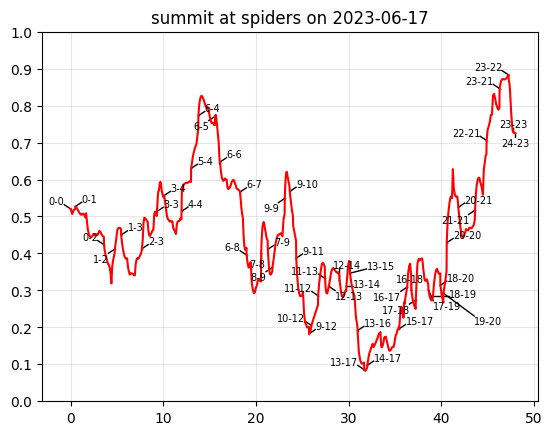

In [14]:
fig, ax = plt.subplots()
plot_game('2023-06-17-COL-OAK', fig, ax)

In [238]:
X_train, X_test, y_train, y_test, normalizer = process_data(DATA, features)

fig, ax = plt.subplots(2,2, figsize=(10, 10))
plot_game('2023-06-16-COL-SLC', fig, ax[0][0])
plot_game('2023-06-09-SLC-COL', fig, ax[0][1])
plot_game('2022-08-20-SLC-COL', fig, ax[1][0])
plot_game('2022-06-10-COL-SLC', fig, ax[1][1])
plt.savefig('charts/slc_lstm.jpg')
plt.close()

/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GAME['temp'] = GAME['home_team_score']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GAME['home_team_score'] = GAME['away_team_score']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [13]:
[x for x in DATA.gameID.unique() if 'COL' in x and '2023' in x]

['2023-05-06-COL-LA',
 '2023-05-20-LA-COL',
 '2023-06-16-COL-SLC',
 '2023-06-04-OAK-COL',
 '2023-06-17-COL-OAK',
 '2023-06-09-SLC-COL',
 '2023-05-13-SEA-COL',
 '2023-05-05-COL-SD']

/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


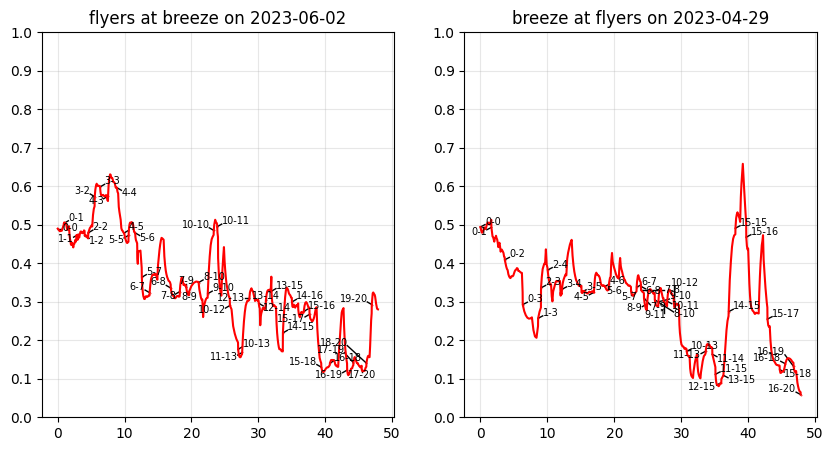

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_game('2023-06-02-CAR-DC', fig, ax[0])
plot_game('2023-04-29-DC-CAR', fig, ax[1])
plt.show()

In [103]:
output = accuracy_model.predict(X_test)

In [104]:
output.shape

(71, 629, 1)

In [150]:
acc_scores, auc_scores = [], []
test_vals, pred_vals = np.array([]), np.array([])
for x in range(len(y_test)):
    mask = y_test[x] != -1
    y_pred = output[x,:,0]
    acc_scores.append(accuracy_score(y_test[x][mask], y_pred[mask] > 0.5))
    test_vals = np.append(test_vals, y_test[x][mask])
    pred_vals = np.append(pred_vals, y_pred[mask])


In [153]:
roc_auc_score(test_vals, pred_vals)

0.8898411318266133

In [199]:
DATA = pd.read_csv('../data/processed/throwing_0627.csv').dropna(how='any', axis=0)
features = ['thrower_x', 'thrower_y', 'possession_num', 'possession_throw',
       'game_quarter', 'quarter_point', 'is_home_team', 'home_team_score',
       'away_team_score','total_points', 'times', 'score_diff']
_, testIDs = train_test_split(DATA.gameID.unique(), test_size=0.2, random_state=42)
DATA = add_team_swap(DATA)
DATA = add_x_swap(DATA)
X_train, y_train = DATA[~DATA.gameID.isin(testIDs)][features], DATA[~DATA.gameID.isin(testIDs)]['home_team_win']
X_test, y_test = DATA[DATA.gameID.isin(testIDs)][features], DATA[DATA.gameID.isin(testIDs)]['home_team_win']

(163484, 16)


/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GAME['temp'] = GAME['home_team_score']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GAME['home_team_score'] = GAME['away_team_score']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_19764/4290610367.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [178]:
# Create a normalizer object
normalizer = MinMaxScaler()
X_train_normalized = normalizer.fit_transform(X_train)
X_test_normalized = normalizer.transform(X_test)
reg = LogisticRegression()
reg.fit(X_train_normalized, y_train)

LogisticRegression()

In [182]:
out = reg.predict_proba(X_test_normalized)[:,1]
print(accuracy_score(y_test, out > 0.5))
print(roc_auc_score(y_test, out))

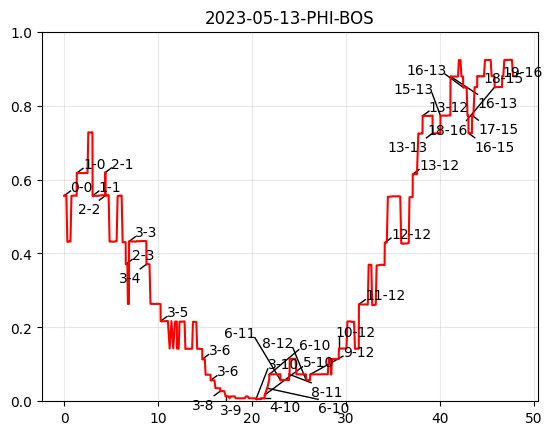

In [192]:
gameID = '2023-05-13-PHI-BOS'
test_game = DATA[DATA.gameID == gameID][features]
test_game = normalizer.transform(test_game)
out = reg.predict_proba(test_game)[:,1]
df = pd.DataFrame(normalizer.inverse_transform(test_game), columns=features)
preds = out
annotations = []
counter = 0
txts, xs, ys = [], [], []
for _, group_df in df[df.times>0].groupby('total_points'):
    counter = counter + 1
    row = group_df.iloc[0]
    txt = f'{int(row.home_team_score)}-{int(row.away_team_score)}'
    x = 48 - row.times/60
    y = out.flatten()[min(group_df.index)]
    txts.append(txt)
    xs.append(x)
    ys.append(y)
fig, ax = plt.subplots()
ax.scatter(xs, ys, c='r', s=0.1)
ta.allocate_text(fig,ax,xs,ys,
                txts,
                x_scatter=xs, y_scatter=ys,
                textsize=10, linecolor='black')


plt.plot(48 - df.times/60, preds, c='r')
plt.grid(alpha=0.3)
plt.title(gameID)
plt.ylim([0,1])
plt.show()

In [198]:
pd.DataFrame({'features':features, 'coeff':reg.coef_.flatten()}).sort_values('coeff')

features      coeff
8    away_team_score -27.016571
0          thrower_x  -0.008234
4       game_quarter  -0.006785
2     possession_num  -0.005338
5      quarter_point   0.000000
1          thrower_y   0.003379
3   possession_throw   0.021032
9       total_points   0.101344
10             times   0.141798
11        score_diff   0.180148
6       is_home_team   0.503253
7    home_team_score  27.177033

In [196]:
reg.coef_.flatten()

array([-8.23372745e-03,  3.37936899e-03, -5.33823537e-03,  2.10315972e-02,
       -6.78513421e-03,  0.00000000e+00,  5.03253494e-01,  2.71770335e+01,
       -2.70165714e+01,  1.01344471e-01,  1.41798102e-01,  1.80148430e-01])

In [213]:
reg = xgb.XGBRegressor(max_depth=3, n_estimators=100)
reg.fit(X_train_normalized, y_train)
out = reg.predict(X_test_normalized)
print(accuracy_score(y_test, out > 0.5))
print(roc_auc_score(y_test, out))

0.8133831217326363
0.8991147863443246


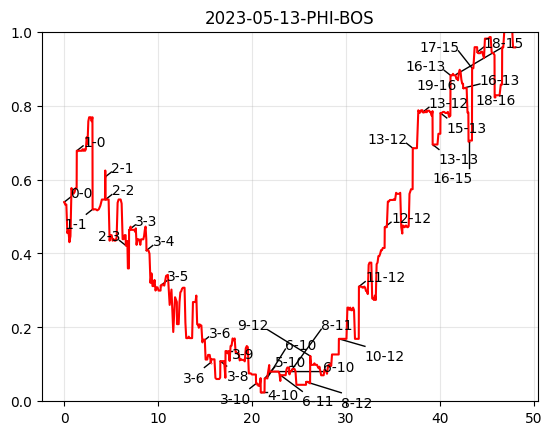

In [214]:
gameID = '2023-05-13-PHI-BOS'
test_game = DATA[DATA.gameID == gameID][features]
test_game = normalizer.transform(test_game)
out = reg.predict(test_game)
df = pd.DataFrame(normalizer.inverse_transform(test_game), columns=features)
preds = out
annotations = []
counter = 0
txts, xs, ys = [], [], []
for _, group_df in df[df.times>0].groupby('total_points'):
    counter = counter + 1
    row = group_df.iloc[0]
    txt = f'{int(row.home_team_score)}-{int(row.away_team_score)}'
    x = 48 - row.times/60
    y = out.flatten()[min(group_df.index)]
    txts.append(txt)
    xs.append(x)
    ys.append(y)
fig, ax = plt.subplots()
ax.scatter(xs, ys, c='r', s=0.1)
ta.allocate_text(fig,ax,xs,ys,
                txts,
                x_scatter=xs, y_scatter=ys,
                textsize=10, linecolor='black')


plt.plot(48 - df.times/60, preds, c='r')
plt.grid(alpha=0.3)
plt.title(gameID)
plt.ylim([0,1])
plt.show()

In [224]:
def plot_game_reg(gameID, fig, ax):
    home_team = DATA[DATA.gameID == gameID].home_teamID.iloc[0]
    away_team = DATA[DATA.gameID == gameID].away_teamID.iloc[0]
    test_game = DATA[DATA.gameID == gameID][features]
    test_game = normalizer.transform(test_game)
    out = reg.predict(test_game)
    df = pd.DataFrame(normalizer.inverse_transform(test_game), columns=features)
    preds = out
    annotations = []
    counter = 0
    txts, xs, ys = [], [], []
    for _, group_df in df.groupby('total_points'):
        counter = counter + 1
        row = group_df.iloc[0]
        txt = f'{int(row.home_team_score)}-{int(row.away_team_score)}'
        x = 48 - row.times/60
        y = out.flatten()[min(group_df.index)]
        txts.append(txt)
        xs.append(x)
        ys.append(y)
    ax.scatter(xs, ys, c='r', s=0.1)
    ta.allocate_text(fig,ax,xs,ys,
                    txts,
                    x_scatter=xs, y_scatter=ys,
                    textsize=7, linecolor='black')


    ax.plot(48 - df.times/60, preds, c='r')
    ax.grid(alpha=0.3)
    ax.set_yticks(np.arange(0,1.1,0.1))
    ax.set_ylim([0,1])
    ax.title.set_text(f'{away_team} at {home_team} on {gameID[:10]}')
    return ax

In [227]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
plot_game_reg('2023-06-16-COL-SLC', fig, ax[0][0])
plot_game_reg('2023-06-09-SLC-COL', fig, ax[0][1])
plot_game_reg('2022-08-20-SLC-COL', fig, ax[1][0])
plot_game_reg('2022-06-10-COL-SLC', fig, ax[1][1])
plt.savefig('charts/slc_xgb.jpg')
plt.close()